Empezamos la limpieza del dataset.

In [1]:
#1. librerias necesarias

import numpy as np 
import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity




#2. Cargamos los dataset y los revisamos un poco

#df_credits =  pd.read_csv('C:/Users/LENOVO/Documents/Henry/Primer_proyecto_integrado_R/datasets/credits.csv')

#print(df_credits.head())
#print(df_credits.shape)
#print(df_credits.columns)
#print(df_credits.dtypes)

#df_credits es un archivo muy pesado, por lo que para subirlo a github, lo convertirmos en parquet. 

#df_credits_parquet = df_credits.to_parquet('C:/Users/LENOVO/Documents/Henry/Primer_proyecto_integrado_R/datasets/df_credits_parquet', engine='pyarrow', compression='snappy')
df_credits = pd.read_parquet('datasets/df_credits_parquet', engine='pyarrow')

df_movies =  pd.read_csv('datasets/movies_dataset.csv')

#print(df_movies.shape)
#print(df_movies.shape)
#print(df_movies.columns)
#print(df_movies.dtypes)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19348\1429073269.py:34: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies =  pd.read_csv('C:/Users/LENOVO/Documents/Henry/Primer_proyecto_integrado_R/datasets/movies_dataset.csv')


In [2]:
#3 Empezamos la limpieza del dataset borrando las columnas video, imdb_id, adult, original_title, poster_path y homepage; incluimos a esta lista production_countries.
df_movies = df_movies.drop(columns=['video','imdb_id','adult','poster_path','homepage','production_countries'],errors='ignore') #no se borra 'original_title' como se sugiere en el ejercicio porque lo necesitamos para una de las funciones.

In [3]:
#4 a) Vamos a desanidar las columnas anidadas de df_movies['belongs_to_collection']). Columna belongs_to_collection. Como en ningun de las funciones se solicita 'poster_path' o 'backdrop_path, no las incluimos en las columnas desanidadas

movieswithoutinf=[] #hay filas en df_movies['belongs_to_collection']) que no tienen ni id o name de colección, las incluimos acá  
Listmovies=[]

for i, movie in enumerate(df_movies['belongs_to_collection']):
    if type(movie) == str:
        x = re.findall(r"'id':\s*(\d+),\s*'name':\s*'([^']+)'", movie) # este nos sirve para todos los nombres, a excepción de los nombres que tienen 's, como McHale's Navy Collection
        if len (x) == 0:            
            y =re.findall(r"'id':\s*(\d+),\s*'name':\s*\"([^\"]+)\"", movie) #este nos sirve para los nombres que tienen 's
            if len (y) == 0:
                movieswithoutinf.append(i)
                Listmovies.append(i)
            else:
                dict_y = {"id":y[0][0],"name":y[0][1]}
                Listmovies.append(dict_y)        
        else: 
            dict_x = {"id":x[0][0],"name":x[0][1]}
            Listmovies.append(dict_x)
    else:
        Listmovies.append(movie)    
            

#len(Listmovies) + len(movieswithoutinf) == df_movies.shape[0]  
#eliminmos las filas que no tienen información 

for u in movieswithoutinf:
    df_movies['belongs_to_collection'][u] = 'null'

#print(df_movies.shape)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19348\1153440433.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['belongs_to_collection'][u] = 'null'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19348\1153440433.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['belongs_to_collection'][u] = 'null'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19348\1153440433.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [4]:
#Convertimos el diccionario Listmovies en columna del dataset Name_Movie. Eliminamos columna 'belongs_to_collection'

Name_Movie_Collection=[]

for d in Listmovies:
    if type(d) == dict:
        Name_Movie_Collection.append(d['name'])
    else:
        d = 'null'       
        Name_Movie_Collection.append(d)  

#print(len(Name_Movie))

#Añadimos la lista al dataframe

df_movies['Name_Movie_Collection'] = Name_Movie_Collection

#print(df_movies.shape)
#print(df_movies['Name_Movie_Collection'].value_counts())

df_movies = df_movies.drop('belongs_to_collection', axis=1, errors='ignore')
df_movies = df_movies.reset_index(drop=True)


In [5]:
#b) Vamos a desanidar la columna genres y lo vamos a poner todos los géneros en un sola columna

Genres=[]
for u in df_movies['genres']:    
    t = re.findall(r"'name':\s*'([^']+)'", u)
    Genres.append(t)

In [6]:
#ponemos la lista en el dataframe y las listas vacias y arreglamos un poco la información en el dataset. 

Corrected_Genres =[]

df_movies['genres']=Genres

for u in df_movies['genres']:
    if len(u) == 0:
        m = 'null'
        Corrected_Genres.append(m)  
    else:
        m = ', '.join(u)
        Corrected_Genres.append(m)
    
df_movies['genres'] = Corrected_Genres
#counts = df_movies['Genres'].value_counts()
#print(counts)

In [7]:
#c) Vamos a desanidar la columna production_companies y lo vamos a poner todas las compañías en un sola columna

companies=[]
for i, u in enumerate(df_movies['production_companies']): 
    if type(u)== float:
        m = "null"
        companies.append(m)
    
    else:
        m = re.findall(r"'name':\s*'([^']+)'", u)
        companies.append(m)   

In [8]:
#ponemos la lista en el dataframe y las listas vacias. Arreglamos un poco la información en el dataset. 
Corrected_companies =[]

df_movies['production_companies']= companies

for u in df_movies['production_companies']:
    if len(u) == 0:
        m = 'null'
        Corrected_companies.append(m)  
    else:
        m = ', '.join(u)
        Corrected_companies.append(m)
    
df_movies['production_companies']= Corrected_companies
#counts = df_movies['production_companies'].value_counts()
#print(counts)

In [9]:
#c) Vamos a desanidar la columna spoken_languages y lo vamos a poner todas las compañías en un sola columna

languages=[]
for i, u in enumerate(df_movies['spoken_languages']): 
    if type(u)== float:
        m = "null"
        languages.append(m)
    elif type(u)==list:
        languages.append(m)    
    else:
        m = re.findall(r"'name':\s*'([^']+)'", u)
        languages.append(m)

#print(languages)

In [10]:
#ponemos la lista en el dataframe y las listas vacias. Arreglamos un poco la información en el dataset. 
Corrected_languages =[]

df_movies['spoken_languages']= languages

for u in df_movies['spoken_languages']:
    if len(u) == 0:
        m = 'null'
        Corrected_languages.append(m)  
    else:
        m = ', '.join(u)
        Corrected_languages.append(m)
    
df_movies['spoken_languages']= Corrected_languages
#counts = df_movies['spoken_languages'].value_counts()
#print(counts)

In [11]:
#df_movies.columns 

In [12]:
#5 a) Debido a que en las funciones nos piden información del actor y del director, la idea es poder sacar esta información y añadirla al dataset df_movies
#creamos un data set actores. Desanidamos todos actores de una películas


actors=[]
for i, u in enumerate(df_credits['cast']): 
    if type(u)== float:
        m = "null"
        actors.append(m)
    elif type(u)==list:        
        actors.append(m)    
    else:
        m = re.findall(r"'name':\s*'([^']+)'", u)
        actors.append(m)
        

#print(len(actors))
#print(df_credits['cast'].shape)


In [13]:
#ponemos la lista en el dataframe y las listas vacias. Arreglamos un poco la información en el dataset. 
Corrected_actors =[]

df_credits['cast']= actors

for u in df_credits['cast']:
    if len(u) == 0:
        m = 'null'
        Corrected_actors.append(m)  
    else:
        m = ', '.join(u)
        Corrected_actors.append(m)
    
df_credits['cast']= Corrected_actors

#print(df_credits['cast'])

In [14]:
#b) Ahora vamos a sacar a todos los directores

directors=[]
for i, u in enumerate(df_credits['crew']): 
    if type(u)== float:
        m = "null"
        directors.append(m)      
    else:
        m = re.findall(r"'job':\s*'Director',\s*'name':\s*'([^']+)'", u)
        directors.append(m)


#print(len(directors))
#print(df_credits['crew'].shape)



In [15]:
#ponemos la lista en el dataframe y las listas vacias. Arreglamos un poco la información en el dataset. 
Corrected_directors =[]

df_credits['crew']= directors

for u in df_credits['crew']:
    if len(u) == 0:
        m = 'null'
        Corrected_directors.append(m)  
    else:
        m = ', '.join(u)
        Corrected_directors.append(m)
    
df_credits['crew'] = Corrected_directors

#print(df_credits['crew'].shape)
#print(df_credits['crew'].value_counts())

df_credits= df_credits.rename(columns={'crew': 'director'})

In [16]:
# 6) Con todo la información desaniadada de una manera conveniente, es hora de unir los datasets. 
# #En este caso, como comparten el ID de la película, la idea es usar esta variable para unirlos

#print(df_movies.dtypes)
#print(df_credits.dtypes)

#al intentar transformar df_movies['id'] a int64, hay celdas que no se dejan, con el siguiente código averiguamos cuáles son:


notint64=[]

for i, u in enumerate(df_movies['id']):
    try:
        x=int(u)
    except:

        notint64.append(i)


#eliminamos esas linea del dataset porque no tiene id de película.

for i in notint64:
    df_movies = df_movies.drop(index=i, errors='ignore')

df_movies['id'] = df_movies['id'].astype('int64') #hago este cambio necesario para combinar los data frames  


df_merged = pd.merge(df_movies, df_credits, on='id', how='inner')

#df_merged

df_merged = df_merged.reset_index(drop=True)


In [17]:
#7) Arreglamos unas inconscistencias 

df_merged[df_merged['production_companies'] == 'n, u, l, l'] ='null'

df_merged[df_merged['spoken_languages'] == 'n, u, l, l'] = 'null'

#8) rellenamos los valores nulos de revenue y budget con 0

#a) Pare revenue. Buscamos en revenue el valor que no se deja sumar, lo que significaria que no es un número

listnotnumber = []
m = 0
for i, o in enumerate(df_merged['revenue'].value_counts().index):
    try:
        m += o
    except:
        listnotnumber.append(i)

#for i in listnotnumber:
    #print(df_merged['revenue'].value_counts().index[i])      
    #print(type(df_merged['revenue'].value_counts().index[i])) #la variables 'null está en string'

nulos= df_merged[df_merged['revenue'] == 'null']

#nulos #acá nos damos cuenta que las filas que tienen null en revenue, no tienen ninguna información en ninguna de las columnas, así que las eliminamos

for x in nulos.index:
    df_merged = df_merged.drop(index=x, errors='ignore')

df_merged = df_merged.reset_index(drop=True)



#b) Pare budget. Buscamos en budget el valor que no se deja transformar en int, lo que significaria que no es un número

listnotnumber2 = []
k = 0
for i , o in enumerate(df_merged['budget'].value_counts().index):
    try:
        x=int(o)
        k += x        
    except:
        listnotnumber2.append(i)

#listnotnumber2 esta lista está vacía, lo que significa que no hay null.

#df_merged.shape


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19348\4273173024.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'null' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_merged[df_merged['production_companies'] == 'n, u, l, l'] ='null'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19348\4273173024.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_merged[df_merged['production_companies'] == 'n, u, l, l'] ='null'


In [18]:
#9 Eliminar todos los campos nulos de release date.

for i, date in enumerate(df_merged['release_date'].isnull()):
    if date is True:
        df_merged = df_merged.drop(index=i, errors='ignore')

#df_merged.shape

#10 extraemos el año de 'release_date'

df_merged['release_date'] = pd.to_datetime(df_merged['release_date'])
df_merged['Year'] = df_merged['release_date'].dt.year

df_merged = df_merged.reset_index(drop=True)



In [19]:
#10 dividimos la columnas revenue / budget teniendo en cuenta que si alguno de los datos es faltante, que es lo mismo que igual a 0, no hacemos el computo 
# y dejamos el campo 'revenue/budget' igual a 0 también

df_merged['revenue'] = df_merged['revenue'].astype(float)
df_merged['budget'] = df_merged['budget'].astype(float)

def revenue_budget (row):
    if row['budget'] == 0 or row['revenue'] == 0:
        return 0
    else:
        return row['revenue'] / row['budget']
    
df_merged['revenue/budget'] = df_merged.apply(revenue_budget, axis=1)

In [20]:
#11 ahora eliminamos los duplicados

df_merged = df_merged.drop_duplicates()

df_merged = df_merged.reset_index(drop=True)

#df_merged.shape 

Ahora creamos las funciones

In [21]:
#1) #def cantidad_filmaciones_dia( Dia ): Se ingresa un día en idioma Español. Debe devolver la cantidad de películas que fueron estrenadas en día
#  consultado en la totalidad del dataset.

def cantidad_filmaciones_dia(Dia):

    dia1 = Dia
    count = 0

    diccionario_traducción = {
        'Lunes':'Monday',
        'Martes':'Tuesday',
        'Miércoles':'Wednesday',
        'Jueves':'Thursday',
        'Viernes':'Friday',
        'Sábado':'Saturday',
        'Domingo':'Sunday'}
    
    if Dia in diccionario_traducción:
        for dates in df_merged['release_date']:
            date = dates.day_name()
            if date == diccionario_traducción[Dia]:
                count += 1
    else: 
        return print('Por favor ingresar el día, sin abreviaciones, en español con la primera letra en mayúscula. Ej: Lunes, no acepta LUNES, lunes, Lun, etc')
    return print(f'{count} películas fueron estrenadas en los días {dia1}')        

#cantidad_filmaciones_dia('Viernes')



In [22]:
#2) #def cantidad_filmaciones_mes( Mes ): Se ingresa un mes en idioma Español. Debe devolver la cantidad de películas que fueron estrenadas en el mes 
# consultado en la totalidad del dataset.
                    

def cantidad_filmaciones_mes(Mes):

    mes1 = Mes
    count = 0

    diccionario_traducción = {
        'Enero': 'January',
        'Febrero': 'February',
        'Marzo': 'March',
        'Abril': 'April',
        'Mayo': 'May',
        'Junio': 'June',
        'Julio': 'July',
        'Agosto': 'August',
        'Septiembre': 'September',
        'Octubre': 'October',
        'Noviembre': 'November',
        'Diciembre': 'December'}
    
    if Mes in diccionario_traducción:
        for months in df_merged['release_date']:
            month = months.month_name()
            if month == diccionario_traducción[Mes]:
                count += 1
    else: 
        return print('Por favor ingresar el mes, sin abreviaciones, en español con la primera letra en mayúscula. Ej: Enero. No acepta enero, En, etc')
    return print(f'{count} películas fueron estrenadas en los mes {mes1}')        


In [23]:
#3) def score_titulo( titulo_de_la_filmación ): Se ingresa el título de una filmación esperando como 
# respuesta el título, el año de estreno y el score.

#se hace unas transformaciones para intentar estandarizar el nombre de las películas

df_merged['original_title'] = df_merged['original_title'].str.title()  # Capitalizar la primera letra de cada palabra
df_merged['original_title'] = df_merged['original_title'].str.replace(r'\s+', ' ', regex=True)  # Reemplazar múltiples espacios por uno solo
df_merged['original_title'] = df_merged['original_title'].str.strip() 

#Y ahora la función
def score_titulo(titulo_de_la_filmación):
    for i, title in enumerate(df_merged['original_title']):
        if titulo_de_la_filmación == title:
            year = df_merged['release_date'][i].year
            popurlaridad = df_merged['popularity'][i]
            return print(f'La película {titulo_de_la_filmación} fue estrenada en el año {year} con un score/popularidad de {popurlaridad}')
            break
    print(f'Ups, la película {titulo_de_la_filmación} no está en mi base. Por favor intenté el título de la película con todas las letras iniciales en mayúscula y con un sólo espacio entre palabras')


#score_titulo('The Telephone Book')
df_merged = df_merged.drop('title', axis=1, errors='ignore')

In [24]:
#4) def get_actor( nombre_actor ): Se ingresa el nombre de un actor que se encuentre dentro de un dataset debiendo devolver el éxito
#  del mismo medido a través del retorno. Además, la cantidad de películas que en las que ha participado y el promedio de retorno. 
# La definición no deberá considerar directores.                    


def get_actor(nombre_actor):

    cantidad_de_películas = 0
    total_revenue = 0

    for i, reparto in enumerate(df_merged['cast']):
        if nombre_actor in reparto:                   
            cantidad_de_películas += 1
            total_revenue += df_merged['revenue'][i]

    if cantidad_de_películas != 0:      
        return  print(f'El actor {nombre_actor} ha participado en {cantidad_de_películas} filmaciones, el mismo ha conseguido un retorno de {total_revenue} con un promedio de {total_revenue/cantidad_de_películas} por filmación')
    else: 
        print(f'Ups, el actor {nombre_actor} no está en mi base.')


#get_actor('Tom Hanks')

df_limp = df_merged[1:1000]

df_limp.to_excel('datos_limpios.xlsx', index=False, engine='openpyxl')

In [25]:
#Deploy de las funciones.

#https://primer-proyecto-integrado-2.onrender.com/

Ahora vamos a realizar la función de recomendación 

In [26]:
#En el ejercicio Henry se sugiere utilizar la similitud de los títulos para que sea una variable del sistema de recomendación
#sin embargo, en este ejercicio se realizará con la descripción de las películas. 

#1)

#comprobamos si los componentes df_merged['overview'] son todos strings y si no, los cambiamos a 'null'

df_merged['overview'] = df_merged['overview'].fillna('null')

# Definir la función de tokenización. eliminamos signos de puntuación, números, dejamos todas las palabras en mi minisculas 
# y tokenizamos las palabras

def tokenize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^a-zA-Zñíá]", " ", text)
        return word_tokenize(text)
    else:
        return 'null'
   
df_merged['overview_clean'] = df_merged['overview'].apply(tokenize_text)       

In [27]:
#eliminamos las stop words
stopwords = nltk.corpus.stopwords.words('english')#cargamos stop words
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]

def eliminar_stop_words(list_sinop):
    if isinstance(list_sinop, list):         
        return [word for word in list_sinop if word.lower() not in stopwords]
    else: 
        return 'null'

df_merged['overview_clean'] = df_merged['overview_clean'].apply(eliminar_stop_words) 



In [28]:
#Hacemos stemming 

stemmer = PorterStemmer()

def stem(list_sinop):
    if isinstance(list_sinop, list):         
        return [stemmer.stem(palabra) for palabra in list_sinop]
    else: 
        return 'null'

df_merged['overview_clean'] = df_merged['overview_clean'].apply(stem) 

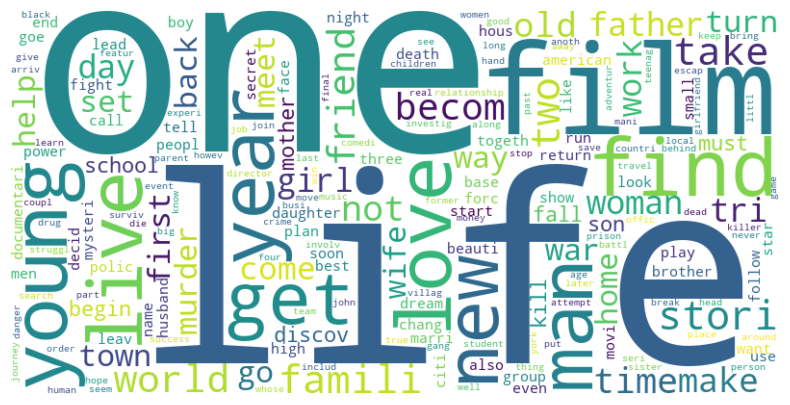

In [29]:
#queremos ahora revisar gráfico de nubes con las frecuencias de las palabras en la sinopsis 

todas_las_sinopsis = df_merged['overview_clean'].tolist()
todas_las_sinopsis = list(itertools.chain(*todas_las_sinopsis))
freq_words = nltk.FreqDist(todas_las_sinopsis)

df_freq_words_sip = pd.DataFrame(list(freq_words.items()), columns = ["Word","Frequency"]) 
df_freq_words_sip.sort_values('Frequency',ascending=False, inplace = True)
df_freq_words_sip.reset_index(drop = True, inplace=True)

word_freq = dict(zip(df_freq_words_sip['Word'], df_freq_words_sip['Frequency']))

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Muestra la nube de palabras usando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.show()

In [30]:
#2) parte de nuestro sistema de recomendación es mirar palabras que son similares en las sinopsis, para hacer esto
#utilizaremos la similitud del coseno

#Debido a que queremos deployar el modelo con Render, tenemos una restricción con la cantidad de datos que vamos a utilizar
#por lo tanto vamos a recortar el dataset a 5000 datos a ver cómo funciona.
#Otra forma de ajustar los datos para que cumpla con los estándares de la versión gratuita de Render es limitando la 
#cantidad de atributos que vamos a usar en el modelo. En este caso nuestro modelo contará con tres atributos:
# genres: utilizando la similiridad del coseno, veremos que películas tienen generos similares
# overview_clean: utilizando la similiridad del coseno, veremos que sinopsis son similares
# vote_average: utilizaremos este como una manera de recomendar las mejores películas que tengan generos y sinopsis similares    

df_ML = df_merged.iloc[:5000]
df_ML = df_ML[['original_title', 'genres', 'overview_clean', 'vote_average']]

def list_to_string(word_list):
    return ' '.join(word_list)

df_ML['overview_clean'] = df_ML['overview_clean'].apply(list_to_string)


#vectorizamos a través de estimadores TF-IDF
vectorizer_sinop = TfidfVectorizer()  # Limita el número de características a 10,000 y descarta términos que aparecen en más del 95% de los documentos

tfidf_matrix_sinop = vectorizer_sinop.fit_transform(df_ML['overview_clean'] )

#aplicamos similitud de coseno
cosine_sim_sinop = cosine_similarity(tfidf_matrix_sinop)

In [31]:
#3) Ahora convertimos géneros utilizando similaridad del coseno 

vectorizer_gen = TfidfVectorizer()  

#vectorizamos a través de estimadores TF-IDF

tfidf_matrix_gen = vectorizer_gen.fit_transform(df_ML['genres'])

cosine_sim_gen = cosine_similarity(tfidf_matrix_gen)

#vectorizer.vocabulary_
#print(tfidf_matrix)

In [32]:
#4)revisamos cómo está la columna vote_average para rellenar. Si existen datos diferentes a números, los eliminaremos

df_ML['vote_average'] = df_ML['vote_average'].astype(float) #la columna era de tipo objeto así que transformamos a 

for i, x in enumerate(df_ML['vote_average']):
    if x is None:
        print(i, x)    
    if pd.isnull(x):
        print(i, x)

#no existen nulos en la columna 'vote_average'  

#revisamos si hay outliers:

for i, x in enumerate(df_ML['vote_average']):
    if x > 10 or x < 0:
        print(i, x)  #no hay outliers


df_ML = df_ML.reset_index(drop=True)


In [38]:
#5) Habiendo finalizado las transformaciones en las columnas. Ahora vamos a realizar las función de recomendación.

#como el máximo vote_average es 10 y, similaridad de coseno da un máximo valor es de 1, para que cada uno de estos
# atributos tengan un peso similar, vamos a definir esta función:

#puntaje de recomendación = (10 *similaridad del coseno género) + (10 *similaridad del coseno sinopsis) + vote_average
#ahora, después de unos intentos, nos damos cuenta que ponerles el mismo peso al género y al vote_average es un error
#ya que si tienen exactamente el mismo genero les dará demasiados puntos y siempre recomendará películas con puntaje 10.

#puntaje de recomendación = (3*similaridad del coseno género) + (10 *similaridad del coseno sinopsis) + (vote_average/4).
#en análisis posteriores lo ideal sería identificar cuáles son los pesos correctos, pero esto está fuera del alcance de 
#este proyecto


def recomendar_peliculas (titulo):

    for i, nombre_pel in enumerate(df_ML['original_title']):
        if nombre_pel == titulo:
            pel = i            
            break

    df_ML['cos_gen'] = cosine_sim_gen[i]
    df_ML['cos_sinop'] = cosine_sim_sinop[i]
    df_ML['recommend_movie_score'] = (df_ML['cos_gen']*3) + (df_ML['cos_sinop']*10) + (df_ML['vote_average']/3)
    df_ordered = df_ML.sort_values(by='recommend_movie_score', ascending=False)
    return df_ordered['original_title'][1:6].tolist()
    

#recomendar_peliculas ('Toy Story')  


['Toy Story 2',
 'Monsters, Inc.',
 'A Close Shave',
 'The Wrong Trousers',
 'Creature Comforts']

In [34]:
#df_ML.to_excel('datos_limpios_recomendar.xlsx', index=False, engine='openpyxl')
#Live_on: https://primer-proyecto-integrado-r.onrender.com